In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras as ks
import numpy as np
from tensorflow.keras import Input
import tensorflow as tf
from sklearn.metrics import f1_score, confusion_matrix
import gc

In [2]:
train = pd.read_csv('../data/split_data/train_stats.csv', index_col=0)
test = pd.read_csv('../data/split_data/test_stats.csv', index_col=0)
train.head()

,tension_index_int,mode_int,std_int,mean_int,var_int,pnn50_int,RMSSD_int,ivr_int,vpr_int,papr_int,...,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20
0,38.040113,795.642857,69.377642,823.428571,8.425460,55.0,70.359079,0.000605,0.000005,0.000180,...,0,0,0,0,0,0,0,0,0,0
1,35.472331,853.238095,69.195100,824.190476,8.395523,50.0,69.460780,0.000605,0.000005,0.000167,...,0,0,0,0,0,0,0,0,0,0
2,35.472331,853.238095,69.072770,824.380952,8.378744,55.0,70.608781,0.000605,0.000005,0.000167,...,0,0,0,0,0,0,0,0,0,0
3,35.472331,853.238095,69.829725,823.238095,8.482324,55.0,71.369461,0.000605,0.000005,0.000167,...,0,0,0,0,0,0,0,0,0,0
4,35.472331,853.238095,72.383634,819.238095,8.835482,60.0,74.592225,0.000605,0.000005,0.000167,...,0,0,0,0,0,0,0,0,0,0


In [3]:

zero_train = train.copy()
zero_test = test.copy()

for column in zero_train.iloc[:, -21:].columns:
    zero_train = zero_train.loc[zero_train[column] == 0]
    zero_test = zero_test.loc[zero_test[column] == 0]

one_train = train.drop(index=zero_train.index)
zero_train = zero_train.sample(one_train.shape[0] // 2)

In [4]:
eq_train = pd.concat((one_train, zero_train), axis=0).sample(2 * zero_train.shape[0])

In [21]:


model = ks.Sequential([
    ks.layers.Input(shape=(21, 1)),

    ks.layers.Conv1D( filters=32, kernel_size=3, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    #ks.layers.MaxPooling1D(2),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),

    ks.layers.Conv1D( filters=32, kernel_size=3, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    #ks.layers.MaxPooling1D(2),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),

    ks.layers.Conv1D( filters=32, kernel_size=3, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    #ks.layers.MaxPooling1D(2),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),

    ks.layers.Conv1D( filters=32, kernel_size=3, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    #ks.layers.MaxPooling1D(2),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),

    ks.layers.Flatten(),
    ks.layers.Dense(32),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    ks.layers.Dense(21, activation=tf.keras.activations.hard_sigmoid)
])

model.compile(optimizer=ks.optimizers.Adam(learning_rate=0.01), loss='mse', metrics='mae')

In [22]:
history = model.fit(x=eq_train.loc[:, 'r-r-0': 'r-r-20'].values.reshape((-1, 21, 1)), y=eq_train.loc[:, 'y0': 'y20'], batch_size=32,
          epochs=200,
          validation_data=(
              test.loc[:, 'r-r-0': 'r-r-20'].values.reshape((-1, 21, 1)),
              test.loc[:, 'y0': 'y20']
          ),
                    shuffle=True,
                    verbose=0)



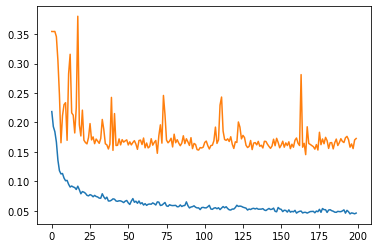

In [23]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])

In [24]:
pred = model.predict(test.loc[:, 'r-r-0': 'r-r-20'].values.reshape((-1, 21, 1)))


result = np.zeros(pred.shape[1] + pred.shape[0] - 1)
count = np.zeros(pred.shape[1] + pred.shape[0] - 1)
for element_index in range(0, pred.shape[1]):
    for row_index in range(0, pred.shape[0]):
        result[row_index + element_index] += pred[ row_index, element_index]
        count[row_index + element_index] += 1


In [25]:
result = np.divide(result, count)
result[result > 0.5] = 1
result[result <= 0.5] = 0

In [26]:
test_array = test.iloc[:, -21:].values

test_y = np.zeros(test_array.shape[1] + test_array.shape[0] - 1)

for element_index in range(0, test_array.shape[1]):
    for row_index in range(0, test_array.shape[0]):
        test_y[row_index + element_index] += test_array[row_index, element_index]

test_y[test_y > 0] = 1

In [27]:
f1_score(y_pred=result, y_true=test_y, average='binary')


0.8081218274111674

In [28]:
confusion_matrix(y_true=test_y, y_pred=result)

array([[748, 121],
       [ 68, 398]], dtype=int64)

In [ ]:
for part in range(0, len(pred)):
    plt.ylim((-0.1, 1.1))
    plt.plot(np.arange(0, 21), pred[part])
    plt.plot(np.arange(0, 21), test.iloc[part, -21:])
    plt.hlines(0.5, 0, 20, colors='r')
    plt.savefig(f'plots/plot{part}.png')
    plt.clf()

In [ ]:
import imageio
import glob
anim_file = 'result.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('plots/plot*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
    writer.append_data(image)
    writer.append_data(image)